<a href="https://colab.research.google.com/github/rnop/PBC-Survival-Analysis/blob/master/Survival_Analysis_Primary_Biliary_Cirrhosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Dataset¶
id: patient identification number

* time: how long patient lived before they died or censored in days
* status: 0=alive, 1=liver transplant, 2=dead
* trt: 1=D-penicillamine, 2=placebo
* age: age of patient in days
* sex: f=female, m=male
* ascites: presence of ascites (0=no, 1=yes)
* hepato: presence of hepatomegaly (0=no, 1=yes)
* spiders: presence of spiders (0=no, 1=yes)
* edema: 0=no edema, 0.5=edema present without diuretics or edema resolved by diuretics, 1=edema with diuretic therapy
* bili: serum bilirubin in mg/dl
* chol: serum cholesterol in mg/dl
* albumin: albumin in gm/dl
* copper: urine copper in ug/day
* alk.phos: alkaline phosphatase in U/L
* ast: AST test evaluating liver enzyme in blood
* trg: triglicerides in mg/dl
* platelet: platelets per cubic ml/1000
* protime: prothrombin time in seconds
* stage: histologic stage of disease

### Install lifelines Survival Analysis Library
https://lifelines.readthedocs.io/en/latest/

In [35]:
! pip install lifelines

### Import Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import warnings
warnings.filterwarnings('ignore')

### Read-in CSV

In [37]:
! wget https://raw.githubusercontent.com/rnop/PBC-Survival-Analysis/master/pbc.csv -P pbc_data -nc

df = pd.read_csv('/content/pbc_data/pbc.csv')
df.head()

File ‘pbc_data/pbc.csv’ already there; not retrieving.



,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1,400,2,1.0,58.765229,f,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,0,1.0,56.446270,f,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,2,1.0,70.072553,m,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,2,1.0,54.740589,f,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,1,2.0,38.105407,f,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        418 non-null    int64  
 1   time      418 non-null    int64  
 2   status    418 non-null    int64  
 3   trt       312 non-null    float64
 4   age       418 non-null    float64
 5   sex       418 non-null    object 
 6   ascites   312 non-null    float64
 7   hepato    312 non-null    float64
 8   spiders   312 non-null    float64
 9   edema     418 non-null    float64
 10  bili      418 non-null    float64
 11  chol      284 non-null    float64
 12  albumin   418 non-null    float64
 13  copper    310 non-null    float64
 14  alk.phos  312 non-null    float64
 15  ast       312 non-null    float64
 16  trig      282 non-null    float64
 17  platelet  407 non-null    float64
 18  protime   416 non-null    float64
 19  stage     412 non-null    float64
dtypes: float64(16), int64(3), object

### Initial Data Exploration and Visualization

In [39]:
print("Treatment Group Sizes:") #Recall 1=D-penicillamine, 2=placebo
print(df['trt'].value_counts())

Treatment Group Sizes:
1.0    158
2.0    154
Name: trt, dtype: int64


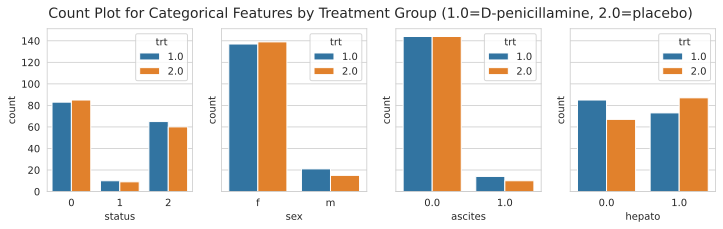

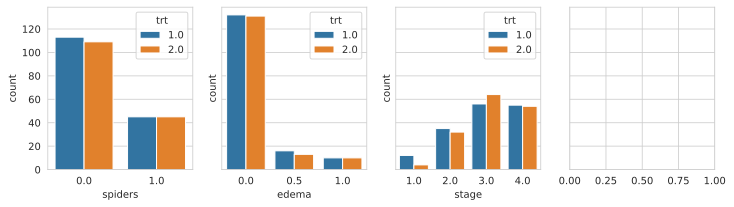

In [40]:
# Visualize Categorical Features
cat_cols1 = ['status', 'sex', 'ascites', 'hepato'] 
fig, axs = plt.subplots(ncols=len(cat_cols1), figsize=(12,3), sharey=True)
for idx, col in enumerate(cat_cols1):
  sns.countplot(df[col], hue=df['trt'], ax=axs[idx])
fig.suptitle('Count Plot for Categorical Features by Treatment Group (1.0=D-penicillamine, 2.0=placebo)', fontsize=14)
plt.show()

cat_cols2 = ['spiders', 'edema', 'stage']
fig, axs = plt.subplots(ncols=len(cat_cols1), figsize=(12,3), sharey=True)
for idx, col in enumerate(cat_cols2):
  sns.countplot(df[col], hue=df['trt'], ax=axs[idx])
plt.show()

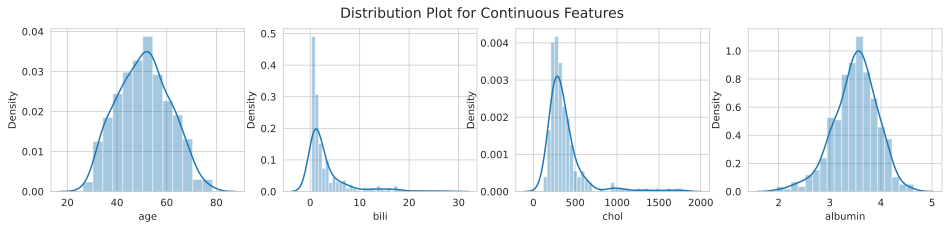

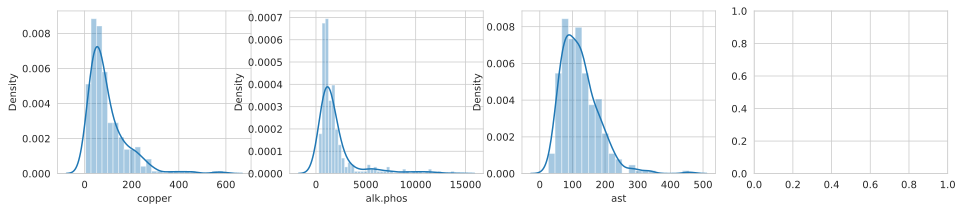

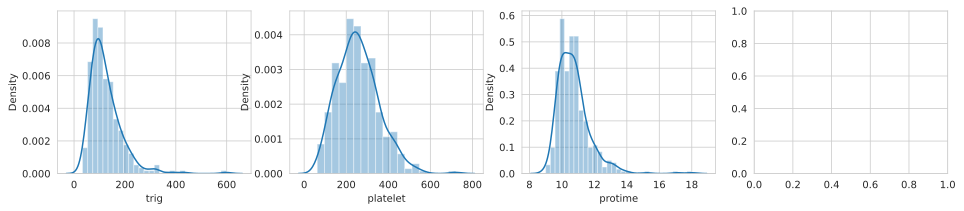

In [41]:
# Visualize Continuous Features
cont_cols1 = ['age', 'bili','chol','albumin'] 
fig, axs = plt.subplots(ncols=len(cont_cols1), figsize=(16,3), sharey=False)
fig.suptitle('Distribution Plot for Continuous Features', fontsize=14)
for idx, col in enumerate(cont_cols1):
  sns.distplot(df[col], ax=axs[idx])
plt.show()

cont_cols2 = ['copper', 'alk.phos', 'ast']
fig, axs = plt.subplots(ncols=len(cont_cols1), figsize=(16,3), sharey=False)
for idx, col in enumerate(cont_cols2):
  sns.distplot(df[col], ax=axs[idx])
plt.show()

cont_cols3 = ['trig','platelet','protime']
fig, axs = plt.subplots(ncols=len(cont_cols1), figsize=(16,3), sharey=False)
for idx, col in enumerate(cont_cols3):
  sns.distplot(df[col], ax=axs[idx])
plt.show()

### Data Pre-Processing
* Re-encode features
* Split dataset into training-testing sets
* Dummy encode categorical features
* Standardize continuous features
* Drop observations with missing features

In [42]:
# Re-Read Data
df = pd.read_csv('/content/pbc_data/pbc.csv')
print("Initial shape:", df.shape)

# Remove patients with liver transplants
df = df[df['status'] != 1] 

# Convert time from days to years
df['time'] = df['time'].apply(lambda x: x / 365.0) # convert days to years

# Re-encode features 
df['status'] = df['status'].apply(lambda x: 1 if x==2 else 0) # re-code status 2 to 1
df['trt'] = df['trt'].apply(lambda x: 1 if x==2 else 0) # re-code treatment arm from 2 to 1, and 1 to 0
df['sex'] = df['sex'].apply(lambda x: 0 if x=='f' else 1) # re-encode sex 'f' to 0, 'm' to 1

Initial shape: (418, 20)


In [43]:
# Count missing observations by feature
df.isna().sum()

id            0
time          0
status        0
trt           0
age           0
sex           0
ascites     100
hepato      100
spiders     100
edema         0
bili          0
chol        127
albumin       0
copper      102
alk.phos    100
ast         100
trig        129
platelet     11
protime       2
stage         6
dtype: int64

In [44]:
# Exploring observations with missing features
df[df['trig'].isna()].sample(10)

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
163,164,0.723288,1,1,43.414100,0,0.0,1.0,1.0,0.5,8.5,NaN,3.34,161.0,1428.0,181.35,NaN,88.0,13.3,4.0
386,387,4.528767,0,0,48.999316,0,NaN,NaN,NaN,0.5,13.6,NaN,3.00,NaN,NaN,NaN,NaN,233.0,9.9,3.0
376,377,5.443836,0,0,32.999316,0,NaN,NaN,NaN,0.0,2.2,NaN,3.76,NaN,NaN,NaN,NaN,253.0,9.9,3.0
384,385,4.479452,0,0,55.000684,0,NaN,NaN,NaN,0.0,0.7,NaN,2.93,NaN,NaN,NaN,NaN,209.0,10.6,3.0
403,404,2.991781,0,0,40.000000,0,NaN,NaN,NaN,0.0,4.6,NaN,3.60,NaN,NaN,NaN,NaN,337.0,10.4,3.0
390,391,3.953425,0,0,40.999316,0,NaN,NaN,NaN,0.0,1.2,NaN,2.80,NaN,NaN,NaN,NaN,120.0,11.0,2.0
328,329,4.005479,1,0,63.000684,0,NaN,NaN,NaN,0.0,0.7,NaN,3.40,NaN,NaN,NaN,NaN,371.0,10.1,4.0
392,393,0.528767,1,0,52.000000,0,NaN,NaN,NaN,0.5,0.7,NaN,2.96,NaN,NaN,NaN,NaN,319.0,9.9,4.0
314,315,7.791781,0,0,54.001369,0,NaN,NaN,NaN,0.0,0.7,NaN,4.03,NaN,NaN,NaN,NaN,226.0,9.8,4.0
335,336,7.219178,0,0,64.999316,0,NaN,NaN,NaN,0.0,2.1,NaN,3.34,NaN,NaN,NaN,NaN,155.0,10.1,4.0


* Looks like if an observation is missing one feature, it is likely to be missing other features as well
* For simplicity, we'll just drop observations that are missing at least one feature

In [45]:
# Drop id and observations with missing values
df.drop('id', axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
# df.reset_index(inplace=True)
print("Drop-NaNs shape:", df.shape)
df.head()

Drop-NaNs shape: (258, 19)


,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1.095890,1,0,58.765229,0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,12.328767,0,0,56.446270,0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,2.772603,1,0,70.072553,1,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,5.273973,1,0,54.740589,0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
6,5.019178,0,1,55.534565,0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0


### Split into Train-Test Sets
* Full Set -> Training Set (75%), Test Set (25%)


In [46]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.25)

### Encode Categorical Features

In [47]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncode Training Set
train_enc = OneHotEncoder(drop='first')
train_enc.fit(train_df[['edema','stage']])

encoded_data = pd.DataFrame(train_enc.transform(train_df[['edema','stage']]).toarray(), 
                            index=train_df.index, 
                            columns=train_enc.get_feature_names(['edema', 'stage']))

train_df = train_df.drop(axis=1, columns=['edema','stage']).join(pd.DataFrame(encoded_data))

# OneHotEncode Testing Set using Training Encoder
encoded_test_data = pd.DataFrame(train_enc.transform(test_df[['edema', 'stage']]).toarray(),
                                 index=test_df.index,
                                 columns=train_enc.get_feature_names(['edema','stage']))

test_df = test_df.drop(axis=1, columns=['edema','stage']).join(pd.DataFrame(encoded_test_data))

### Standardize Continuous Features

In [48]:
cont_cols = ['age', 'bili', 'chol', 'albumin', 'copper','alk.phos',
               'ast','trig','platelet','protime']

train_mean = train_df.loc[:, cont_cols].mean()
train_std = train_df.loc[:, cont_cols].std()

# Standardize Training Set
train_df.loc[:, cont_cols] = (train_df.loc[:, cont_cols] - train_mean) / train_std

# Standardize Testing Set using Training Set Statistics
test_df.loc[:, cont_cols] = (test_df.loc[:, cont_cols] - train_mean) / train_std

### Survival Analysis
* Kaplan-Meier Survival Estimates
* Log-Rank Test for Comparison Between Groups
* Cox Proportional Hazards Model (Cox Regression)
* Random Survival Forests

### Kaplan-Meier Survival Estimates
* The **Kaplan-Meier Product-Limit Method** is a non-parametric technique used for estimating the survival function $S(t)$
* We have **survival times** for $n$ individuals
* Where an $r$ number of these individual's survival times are larger a specified time $t$ 
* Therefore, we say that the probability of an individual surviving longer than $t$ units of time is $\frac{r}{n}$
* We can build Kaplan-Meier Survival Curves of two different groups (e.g. Treatment Group vs Control Group)

$$ S(t) = P(T>t) = \frac{r}{n} $$ 

### Log-Rank Test
* The **Log-Rank Test** is a statistical test used to detect if the survival curves of two different groups are statistically different or not
* Very useful in comparing treatment vs control groups, gender differences, etc. 
* A significant p-value (<0.05) will suggest that there is a statistically significant difference in the survival experience between groups
* **Proportional Hazards Assumption**: the ratio of the two mortality rates of each group must be constant over time

$H_0$: there is no difference in survival experience between groups

$H_A$: there is a difference in survival experience between groups

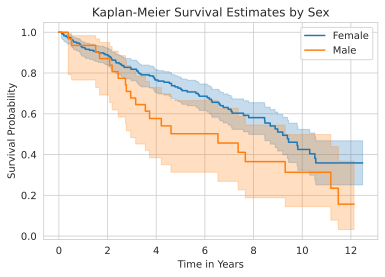

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.53 0.03      4.91

In [49]:
from lifelines import KaplanMeierFitter

# sex: 0=female, 1=male
sex_f = df['sex'] == 0

kmf = KaplanMeierFitter()
kmf.fit(df[sex_f]['time'], df[sex_f]['status'], label='Female')
kmf.plot()

kmf.fit(df[~sex_f]['time'], df[~sex_f]['status'], label='Male')
kmf.plot()
plt.title('Kaplan-Meier Survival Estimates by Sex')
plt.xlabel('Time in Years')
plt.ylabel('Survival Probability')
plt.show()

from lifelines.statistics import logrank_test
results = logrank_test(df[sex_f]['time'], df[~sex_f]['time'], 
                       df[sex_f]['status'], df[~sex_f]['status'])

results.print_summary()

* The p-value of 0.03 suggests there's a significant difference in survival experience between genders.

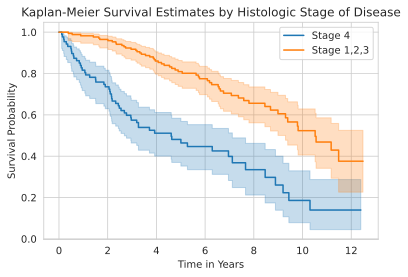

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          40.24 <0.005     32.05

In [50]:
from lifelines import KaplanMeierFitter

# stage: histologic stage of disease
stage4 = df['stage'] == 4

kmf = KaplanMeierFitter()
kmf.fit(df[stage4]['time'], df[stage4]['status'], label='Stage 4')
kmf.plot()

kmf.fit(df[~stage4]['time'], df[~stage4]['status'], label='Stage 1,2,3')
kmf.plot()
plt.title('Kaplan-Meier Survival Estimates by Histologic Stage of Disease')
plt.xlabel('Time in Years')
plt.ylabel('Survival Probability')
plt.show()

from lifelines.statistics import logrank_test
results = logrank_test(df[stage4]['time'], df[~stage4]['time'], 
                       df[stage4]['status'], df[~stage4]['status'])

results.print_summary()

* The p-value of <0.005 suggests that the survival experiences of patients of different stages of the disease is statistically significant

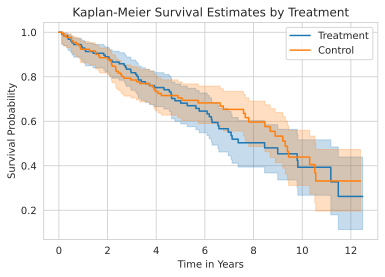

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.33 0.56      0.83

In [51]:
from lifelines import KaplanMeierFitter

# Recall trt was re-coded 2->1, 1->0
# trt: 0=D-penicillamine, 1=placebo 
trt = df['trt'] == 0

kmf = KaplanMeierFitter()
kmf.fit(df[trt]['time'], df[trt]['status'], label='Treatment')
kmf.plot()

kmf.fit(df[~trt]['time'], df[~trt]['status'], label='Control')
kmf.plot()
plt.title('Kaplan-Meier Survival Estimates by Treatment')
plt.xlabel('Time in Years')
plt.ylabel('Survival Probability')
plt.show()

from lifelines.statistics import logrank_test
results = logrank_test(df[trt]['time'], df[~trt]['time'], 
                       df[trt]['status'], df[~trt]['status'])

results.print_summary()

* The p-value of 0.56 suggests that the survival experience of patients treated with D-penicillamine is no different than the survival experience of patients receiving placebo

### Cox Proportional Hazards Model (Cox Regression)
* The Cox proportional hazards model is a semi-parametric regression technique used to model survival data when several covariates of interest are being investigated for their effect on survivability
* **Proportional Hazards Assumption**: the ratio of the two hazard rates of each group must be constant over time
* Unlike Kaplan-Meier Curves and LogRank Tests which compare **univariate** predictors that are categorical (eg. treatment vs control, female vs male), Cox Regression allows for **multivariate** predictors that can be continuous or categorical
* The Cox model is expressed by the **hazard function** denoted $h(t)$
* We interpret the model as the risk/hazard of dying at any time $t$

$$ h(t) = h_0(t) * exp(b_1x_1 + b_2x_2 + ... + b_px_p )$$

* $ h_0(t) $ is known as the **baseline hazard** which corresponds to when all covariates $x_1, x_2, ..., x_p$ is 0 and can be thought of as simply the intercept as a function over time
* Coefficients $b_1, b_2, ..., b_p$ measure the effect size of the covariates

In [52]:
train_df.head()

,time,status,trt,age,sex,ascites,hepato,spiders,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,edema_0.5,edema_1.0,stage_2.0,stage_3.0,stage_4.0
244,4.904110,0,1,-0.493623,0,0.0,1.0,0.0,-0.569412,-0.397611,0.269805,-0.580418,-0.553197,-1.181555,1.669755,0.473230,-1.105231,0.0,0.0,0.0,1.0,0.0
102,0.301370,1,1,-0.195120,0,1.0,1.0,1.0,-0.156676,-0.758087,0.322832,-0.472521,-0.315031,-0.049103,-0.338336,-1.617636,0.357129,0.0,1.0,0.0,0.0,1.0
141,6.627397,1,1,0.437214,0,0.0,1.0,0.0,-0.482520,-0.011690,-0.180923,-0.916097,-0.589991,0.214258,-0.589347,0.237337,-0.812759,0.0,0.0,1.0,0.0,0.0
159,7.594521,0,1,0.591073,0,0.0,0.0,0.0,-0.569412,-0.635101,0.190265,-1.000016,-0.742138,-0.786514,-0.033536,-0.395284,-0.227815,0.0,0.0,0.0,1.0,0.0
111,9.438356,1,1,0.412125,0,0.0,1.0,1.0,-0.265290,-0.423056,0.322832,-0.088889,-0.573085,1.267701,-0.553488,-1.338854,1.039564,0.0,0.0,0.0,0.0,1.0


In [51]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex

cph = CoxPHFitter()
cph.fit(train_df, duration_col='time')